In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from tensorflow.keras import backend as K
import argparse
import os
import sys
from random import getrandbits

In [2]:
def VGG11():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(160,101,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),

        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),

        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.Dense(30,activation='softmax')
    ])
    
    return model

In [17]:
def VGG19():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(160,101,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.Dense(30,activation='softmax')
    ])
    
    return model

In [3]:
def random_onoff():                # randomly turns on or off
    return bool(getrandbits(1))


def augment_signal(y, sr, quiet=True):
    count_changes = 0
    allow_pitch, allow_dyn, allow_noise = True, True, True
    y_mod = y
    # change pitch (w/o speed)
    if (allow_pitch) and random_onoff():
        bins_per_octave = 24  # pitch increments are quarter-steps
        pitch_pm = 4  # +/- this many quarter steps
        pitch_change = pitch_pm * 2 * (np.random.uniform() - 0.5)
        if not quiet:
            print("    pitch_change = ", pitch_change)
        y_mod = librosa.effects.pitch_shift(y, sr, n_steps=pitch_change, bins_per_octave=bins_per_octave)
        count_changes += 1
    # change dynamic range
    if (allow_dyn) and random_onoff():
        dyn_change = np.random.uniform(low=0.5, high=1.1)  # change amplitude
        if not quiet:
            print("    dyn_change = ", dyn_change)
        y_mod = y_mod * dyn_change
        count_changes += 1
        # add noise
    if (allow_noise) and random_onoff():
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        if random_onoff():
            if not quiet:
                print("    gaussian noise_amp = ", noise_amp)
            y_mod += noise_amp * np.random.normal(size=len(y))
        else:
            if not quiet:
                print("    uniform noise_amp = ", noise_amp)
            y_mod += noise_amp * np.random.uniform(size=len(y))
        count_changes += 1

    # last-ditch effort to make sure we made a change (recursive/sloppy, but...works)
    if (0 == count_changes):
        if not quiet:
            print("No changes made to signal, trying again")
        y_mod = augment_signal(y_mod, sr, quiet=quiet)

    return y_mod


def spect_loader(path, window_size=.02, window_stride=.01, window='hamming', normalize=True, max_len=101, augment=False):
    y, sr = sf.read(path)
    y_original_len = len(y)
    
    if augment:
        y = augment_signal(y, sr)
    if not len(y) == y_original_len:
        print('augmentation ruined the audio files length!!!')
        exit()
    
    try:
        n_fft = int(sr * window_size)
    except:
        print(path)

    win_length = n_fft
    hop_length = int(sr * window_stride)
    
    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
    
    spect, phase = librosa.magphase(D)
    spect = np.log1p(spect)
    real_features_len = spect.shape[1]
    
    # make all spects with the same dims
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:, :max_len]

    if spect.shape[0] < 160:
        pad = np.zeros((160 - spect.shape[0], spect.shape[1]))
        spect = np.vstack((spect, pad))
    elif spect.shape[0] > 160:
        spect = spect[:160, :]
    spect = np.resize(spect, (spect.shape[0], spect.shape[1], 1))
    #spect = torch.FloatTensor(spect) 
    
    #normalization to zero-mean and one-std
    normalize = True
    if normalize:
        mean = np.mean(spect)
        std = np.std(spect)
        if std != 0:
            spect = spect - mean
            spect = spect / std
            
    return spect, len(y), real_features_len, sr

In [4]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if (os.path.isdir(os.path.join(dir, d)))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

AUDIO_EXTENSIONS = ['.wav', '.WAV']

def is_audio_file(filename):
    return any(filename.endswith(extension) for extension in AUDIO_EXTENSIONS)

In [5]:
def DataLoader(path, window_size, window_stride, window_type, normalize, max_len):
    classes, class_to_idx = find_classes(path)

    spects = []
    root_dir = os.path.expanduser(path)
    count = 0

    for data in sorted(os.listdir(root_dir)):
        d = os.path.join(root_dir, data)
        if not os.path.isdir(d):
            continue
        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_audio_file(fname):
                    path = os.path.join(root, fname)
                    label = os.path.join(root, fname.replace(".wav", ".wrd"))
                    item = (path, class_to_idx[data], label)
                    spects.append(item)
                    count += 1

    if len(spects) == 0:
        raise (RuntimeError("Found 0 sound files in subfolders of: " + path + "Supported audio file extensions are: " + ",".join(AUDIO_EXTENSIONS)))

    dataset = []

    for index in range(np.shape(spects)[0]):
        data_dir, target, label_path = spects[index]
        spect, _, _, _ = spect_loader(data_dir, window_size, window_stride, window_type, normalize, max_len)
        dataset.append((spect, target))
    
    features = np.zeros([np.shape(dataset)[0]] + list(np.shape(dataset[0][0])))
    labels = np.zeros([np.shape(dataset)[0],30])
    
    for i in range(np.shape(dataset)[0]):
        labels[i,dataset[i][1]] = 1
        features[i,:,:,:] = dataset[i][0]
    
    return features, labels

In [6]:
# Training settings
parser = argparse.ArgumentParser(
    description='ConvNets for Speech Commands Recognition')
parser.add_argument('--train_path', default='split_Google_Command/train',
                    help='path to the train data folder')
parser.add_argument('--test_path', default='split_Google_Command/test',
                    help='path to the test data folder')
parser.add_argument('--valid_path', default='split_Google_Command/validation',
                    help='path to the valid data folder')
parser.add_argument('--batch_size', type=int, default=32,
                    metavar='N', help='training and valid batch size')
parser.add_argument('--test_batch_size', type=int, default=100,
                    metavar='N', help='batch size for testing')
parser.add_argument('--arc', default='VGG11',
                    help='network architecture: VGG11, VGG13, VGG16, VGG19')
parser.add_argument('--epochs', type=int, default=100,
                    metavar='N', help='number of epochs to train')
parser.add_argument('--lr', type=float, default=0.001,
                    metavar='LR', help='learning rate')
parser.add_argument('--momentum', type=float, default=0.9,
                    metavar='M', help='SGD momentum, for SGD only')
parser.add_argument('--optimizer', default='adam',
                    help='optimization method: sgd | adam')
parser.add_argument('--cuda', default=True, help='enable CUDA')
parser.add_argument('--seed', type=int, default=1234,
                    metavar='S', help='random seed')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='num of batches to wait until logging train status')
parser.add_argument('--patience', type=int, default=5, metavar='N',
                    help='how many epochs of no loss improvement should we wait before stop training')

# feature extraction options
parser.add_argument('--max_len', type=int, default=101,
                    help='window size for the stft')
parser.add_argument('--window_size', default=.02,
                    help='window size for the stft')
parser.add_argument('--window_stride', default=.01,
                    help='window stride for the stft')
parser.add_argument('--window_type', default='hamming',
                    help='window type for the stft')
parser.add_argument('--normalize', default=True,
                    help='boolean, wheather or not to normalize the spect')
parser.add_argument('--save_folder', type=str,  default='gcommand_pretraining_model/',
                    help='path to save the final model')
parser.add_argument('--class_num', type=int,  default=30,
                    help='number of classes to classify')

args = parser.parse_args(args=[])
print(args)

Namespace(arc='VGG11', batch_size=32, class_num=30, cuda=True, epochs=100, log_interval=100, lr=0.001, max_len=101, momentum=0.9, normalize=True, optimizer='adam', patience=5, save_folder='gcommand_pretraining_model/', seed=1234, test_batch_size=100, test_path='split_Google_Command/test', train_path='split_Google_Command/train', valid_path='split_Google_Command/validation', window_size=0.02, window_stride=0.01, window_type='hamming')


In [7]:
data_train, labels_train = DataLoader(args.train_path, window_size=args.window_size, window_stride=args.window_stride, 
                           window_type=args.window_type, normalize=args.normalize, max_len=args.max_len)

data_val, labels_val = DataLoader(args.valid_path, window_size=args.window_size, window_stride=args.window_stride, 
                           window_type=args.window_type, normalize=args.normalize, max_len=args.max_len)

In [3]:
def cc_from_logits(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True, axis=-1)

In [24]:
clf = VGG19()
clf.compile(loss=['categorical_crossentropy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
clf_train = clf.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=100, batch_size=32, shuffle=True, callbacks=[early_stopping])
scores = clf.evaluate(data_val, labels_val)
print("Accuracy: %.2f%%" %(scores[1]*100))

Train on 51088 samples, validate on 6798 samples
Epoch 1/100
51088/51088 [==============================] - 194s 4ms/sample - loss: 6.2709 - acc: 0.2515 - val_loss: 4.2335 - val_acc: 0.4500
Epoch 2/100
51088/51088 [==============================] - 190s 4ms/sample - loss: 0.8893 - acc: 0.7429 - val_loss: 0.6871 - val_acc: 0.8127
Epoch 3/100
51088/51088 [==============================] - 190s 4ms/sample - loss: 0.5362 - acc: 0.8450 - val_loss: 0.7075 - val_acc: 0.8189
Epoch 4/100
51088/51088 [==============================] - 191s 4ms/sample - loss: 0.3816 - acc: 0.8882 - val_loss: 0.4958 - val_acc: 0.8728
Epoch 5/100
51088/51088 [==============================] - 190s 4ms/sample - loss: 0.2788 - acc: 0.9186 - val_loss: 0.3680 - val_acc: 0.8931
Epoch 6/100
51088/51088 [==============================] - 190s 4ms/sample - loss: 0.2394 - acc: 0.9291 - val_loss: 0.3462 - val_acc: 0.9066
Epoch 7/100
51088/51088 [==============================] - 190s 4ms/sample - loss: 0.2143 - acc: 0.9372 -

In [25]:
clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 160, 101, 64)      640       
_________________________________________________________________
batch_normalization_48 (Batc (None, 160, 101, 64)      256       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 160, 101, 64)      36928     
_________________________________________________________________
batch_normalization_49 (Batc (None, 160, 101, 64)      256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 80, 50, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 80, 50, 128)       73856     
_________________________________________________________________
batch_normalization_50 (Batc (None, 80, 50, 128)      

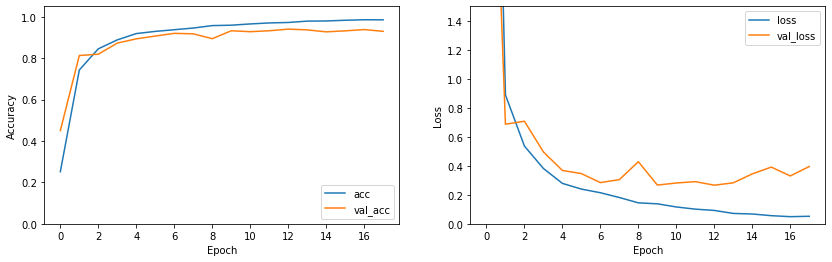

In [45]:
#Plot accuracy vs epoch
plt.figure(figsize=(14,4))
plt.subplot(121)

#### Fill in plot ####
plt.plot(clf_train.history['acc'], label='acc')
plt.plot(clf_train.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
x = range(0,17,2)
#plt.xlim([-0.5, 17])
plt.xticks(x)
plt.ylim([0, 1.05])
plt.legend(loc='lower right')

#Plot loss vs epoch
#### Fill in plot ####
plt.subplot(122)
plt.plot(clf_train.history['loss'], label='loss')
plt.plot(clf_train.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x)
plt.ylim([0, 1.5])
plt.legend(loc='upper right')

In [34]:
clf.save("Pretrain_earlyStopping.h5")

In [35]:
PretrainedModel = tf.keras.models.load_model("Pretrain_earlyStopping.h5")

In [36]:
data_test, labels_test = DataLoader(args.test_path, window_size=args.window_size, window_stride=args.window_stride, 
                           window_type=args.window_type, normalize=args.normalize, max_len=args.max_len)

In [37]:
scores, accuracy = clf.evaluate(data_test, labels_test, batch_size=100)

6835/6835 [==============================] - 7s 1ms/sample - loss: 0.2555 - acc: 0.9358


In [39]:
print(accuracy)

0.93577176
